### Setting and Import

In [1]:
!pip install -q -U tensorflow==2.15.1
!pip install -q -U keras_cv
# !pip show tensorflow

In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
%cd /content/drive/My Drive/Miru_DreamBooth

In [3]:
import math
import keras_cv
import tensorflow as tf
from imutils import paths
import matplotlib.pyplot as plt
plt.style.use('bmh')

from utils import *
from constants import *
from training_data import *

In [ ]:
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Found GPU:", gpu)
        strategy = tf.distribute.MirroredStrategy(devices=None)
    else:
        print("GPU not found.")
        strategy = tf.distribute.get_strategy()
except RuntimeError as e:
    print(e)

print("REPLICAS:", strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.AUTOTUNE

Found GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
REPLICAS: 1


## Data

In [47]:
instance_images_dir = f"{PATH}/instance-images-sqr"
class_images_dir = f"{PATH}/class-images"
instance_image_paths = list(paths.list_images(instance_images_dir))
class_image_paths = list(paths.list_images(class_images_dir))

num_instance_images = len(instance_image_paths)
num_class_images = len(class_image_paths)
print(f"Number of instance images: {num_instance_images}")
print(f"Number of class images: {num_class_images}")

Number of instance images: 10
Number of class images: 220


### Instance Images

Here I use 10 photos of a white cat as the instance images. Set **unique_id** as **'miru'**, the name of the cat.

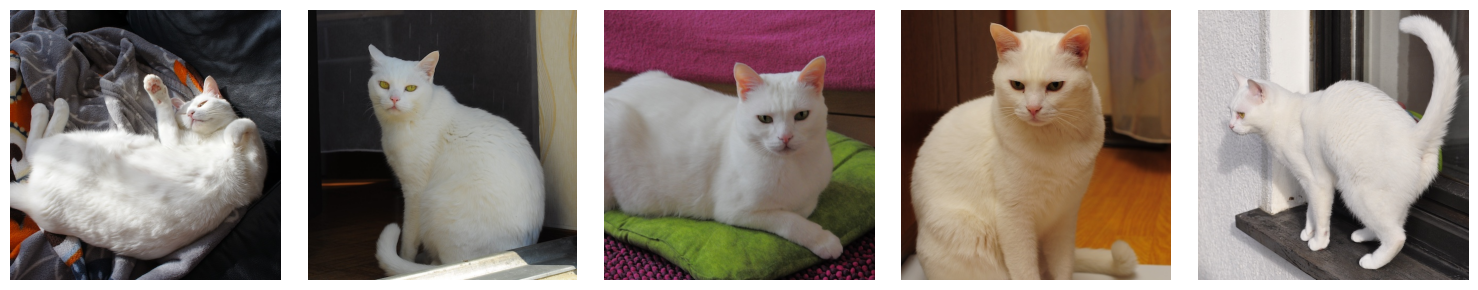

In [47]:
# display instance images
plot_images(load_images(instance_image_paths[:5]))

### Class Images

220 class images were generated from the Stable Diffusion model before fine-tuning with a prompt 'a photo of a cat'. **class_label** set to **'cat'**.

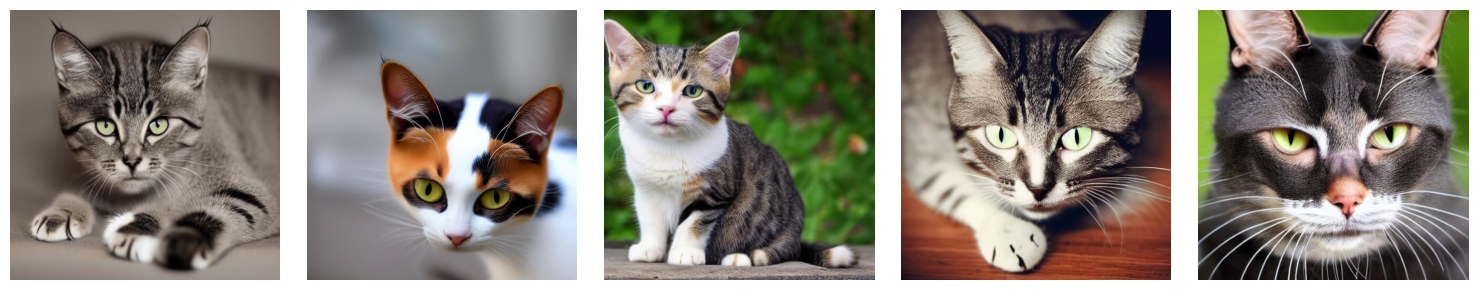

In [16]:
# display class images
plot_images(load_images(class_image_paths[:5]))

## Data Processor

**DataProcessor** includes 
- processing and embedding of texts, 
- processing and augmentation of images, and 
- assembly of datasets.

In [48]:
from data_processor import DataProcessor

dp = DataProcessor(instance_image_paths, class_image_paths, UNIQUE_ID, CLASS_LABEL)
print(f'unique_id: {UNIQUE_ID}, class_lable: {CLASS_LABEL}\n')

instance_dataset = dp.assemble_dataset()
class_dataset = dp.assemble_dataset(instance_only=False)
train_dataset = tf.data.Dataset.zip((instance_dataset, class_dataset))

sample_batch = next(iter(train_dataset))
print(sample_batch[0].keys(), sample_batch[1].keys())
for k in sample_batch[0].keys():
    print(k, sample_batch[0][k].shape)
for k in sample_batch[1].keys():
    print(k, sample_batch[1][k].shape)

unique_id: miru, class_lable: cat

dict_keys(['instance_images', 'instance_embedded_texts']) dict_keys(['class_images', 'class_embedded_texts'])
instance_images (1, 512, 512, 3)
instance_embedded_texts (1, 77, 768)
class_images (1, 512, 512, 3)
class_embedded_texts (1, 77, 768)


## DreamBooth Training

**DreamBooth** can learn and replicate the appearance or style of specific subjects with just a few instance images. It has the ability to understand and preserve the unique characteristics of a given subject while placing them into new environments or contexts. By fine-tuning a pretrained generator model, it finds a direction in the generator's latent space that can adjust the image to include the instance subject, while preserving the rest of the textual content.

Here I experiment Stable Diffusion model with four combinations of the learning_rate and max_train_steps.

| Model   | Learning Rate    | Max Train Steps | 
|---------|------------------|-----------------|
| Model 1 | 1e-6  | 600             | 
| Model 2 | 1e-6  | 900             | 
| Model 3 | 3e-6  | 600             | 
| Model 4 | 3e-6  | 900             | 

**learning_rate** controls the speed of a model's learning, determines the size of the steps for updating weights in each iteration. If it is set too high, the model may converge too quickly and overshoot the optimum. Conversely, if too low, there is a risk of getting stuck in a local optimum instead of finding the global optimum.

**max_train_steps** defines the upper limit on the number of iterations the model will perform throughout the training process. Each iteration includes one forward pass and one backward pass. This parameter helps control the duration of training and prevent overfitting. 

In [ ]:
from dreambooth_trainer import DreamBoothTrainer

# Set the global policy for mixed precision
tf.keras.mixed_precision.set_global_policy("mixed_float16")
use_mp = True

# create ImageEncoder instance
image_encoder = keras_cv.models.stable_diffusion.ImageEncoder()

# create DreamBoothTrainer instance
dreambooth_trainer = DreamBoothTrainer(
    diffusion_model=keras_cv.models.stable_diffusion.DiffusionModel(RESOLUTION, RESOLUTION, MAX_PROMPT_LENGTH),
    vae=tf.keras.Model(image_encoder.input, image_encoder.layers[-2].output),
    noise_scheduler=keras_cv.models.stable_diffusion.NoiseScheduler(),
    use_mixed_precision=use_mp
    )

# set combinations of learning rates and max_train_steps
combinations = [(1e-6, 600), (1e-6, 900), (3e-6, 600), (3e-6, 900)]

beta_1, beta_2 = 0.9, 0.999
weight_decay = 1e-2
epsilon = 1e-08

# Train the model with each combination
for learning_rate, max_train_steps in combinations:
    optimizer = tf.keras.optimizers.experimental.AdamW(
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        beta_1=beta_1,
        beta_2=beta_2,
        epsilon=epsilon,
    )
    dreambooth_trainer.compile(optimizer=optimizer, loss="mse")

    # Calculate the number of epochs based on max_train_steps
    num_update_steps_per_epoch = train_dataset.cardinality()
    epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)
    print(f"Training with lr={learning_rate}, steps={max_train_steps} for {epochs} epochs.")

    # Setup the checkpoint path and callback
    ckpt_path = f"{PATH}/weights_{learning_rate}_{max_train_steps}.h5"
    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path,
        save_weights_only=True,
        monitor="loss",
        mode="min"
    )
    
    dreambooth_trainer.fit(train_dataset, epochs=epochs, callbacks=[ckpt_callback])


3439090152/3439090152 [==============================] - 9s 0us/step
Training with lr=1e-06, steps=600 for 3 epochs.
Epoch 1/3


Instructions for updating:
Use fn_output_signature instead


220/220 [==============================] - 397s 581ms/step - loss: 0.1215
Epoch 2/3
220/220 [==============================] - 155s 697ms/step - loss: 0.1243
Epoch 3/3
220/220 [==============================] - 156s 708ms/step - loss: 0.1269
Training with lr=1e-06, steps=900 for 5 epochs.
Epoch 1/5
220/220 [==============================] - 360s 587ms/step - loss: 0.1059
Epoch 2/5
220/220 [==============================] - 153s 697ms/step - loss: 0.1251
Epoch 3/5
220/220 [==============================] - 157s 698ms/step - loss: 0.1231
Epoch 4/5
220/220 [==============================] - 152s 681ms/step - loss: 0.1126
Epoch 5/5
220/220 [==============================] - 154s 685ms/step - loss: 0.1128
Training with lr=3e-06, steps=600 for 3 epochs.
Epoch 1/3
220/220 [==============================] - 366s 584ms/step - loss: 0.1206
Epoch 2/3
220/220 [==============================] - 155s 698ms/step - loss: 0.1092
Epoch 3/3
220/220 [==============================] - 156s 694ms/step - los

In [ ]:
# continue training

Training with lr=3e-06, steps=900 for 5 epochs.
Epoch 1/5


Instructions for updating:
Use fn_output_signature instead


220/220 [==============================] - 398s 596ms/step - loss: 0.1294
Epoch 2/5
220/220 [==============================] - 157s 701ms/step - loss: 0.1117
Epoch 3/5
220/220 [==============================] - 160s 712ms/step - loss: 0.1091
Epoch 4/5
220/220 [==============================] - 159s 713ms/step - loss: 0.1175
Epoch 5/5
220/220 [==============================] - 155s 701ms/step - loss: 0.0894


### Loss History

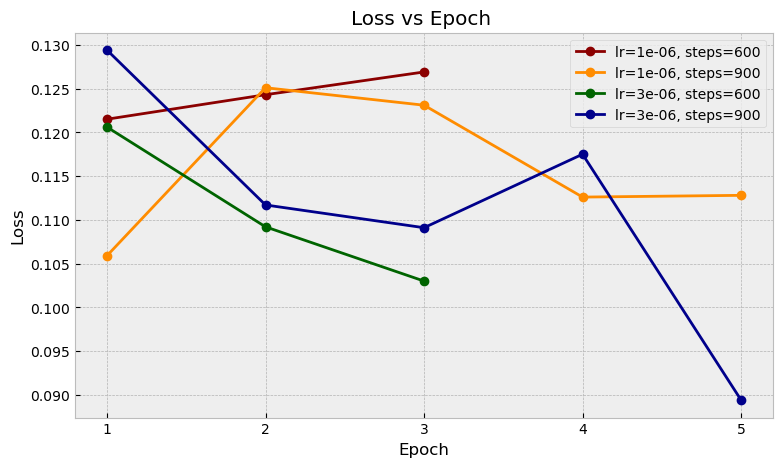

<Figure size 640x480 with 0 Axes>

In [8]:
colors = ['darkred', 'darkorange', 'darkgreen', 'darkblue']
plt.figure(figsize=(9, 5))
for (label, data), color in zip(TRAINING_DATA.items(), colors):
    plt.plot(data["epochs"], data["loss"], marker='o', linestyle='-', label=label, color=color)

plt.title('Loss vs Epoch ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, 6))
plt.legend()
plt.grid(True)
plt.show()
plt.tight_layout()


The graph above shows the loss history for four models with different learning rates and max_train_steps combinations. 

It can be observed that, for the model and dataset of this task, a learning rate of 1e-6 may be too low, resulting in insufficient learning during the training process. A too low learning rate might prevent the model from effectively updating and optimizing its weights within the given number of training steps, leading to fluctuations in the loss values.

For this task, a learning rate of 3e-6 is relatively more appropriate, as the loss decreases with the increase in training epochs. The model with steps=900 experiences oscillations at epoch 4, but achieves the lowest loss value of 0.0894 at epoch 5, it's the best among the four models. 

For a comparison of the models' generated images, please refer to this [notebook](https://github.com/elfchildRichter/DreamBooth_Subject_Driven_Generation/blob/main/generated_images.ipynb).